# [Graph Attention Network](https://arxiv.org/abs/1710.10903)

The way in which *GCN* aggregates is structure-dependent, which may hurt its generalizability.<br>
*GAT* proposes an alternative way to combine local graph structure and features by weighting neighbor features with feature dependent and structure free normalization, in the style of *attention*. <br>
This is different from what is done in [*GraphSAGE*](https://www-cs-faculty.stanford.edu/people/jure/pubs/graphsage-nips17.pdf), i.e. average over all neighbors.

## Graph Convolution operation

The key difference between GAT and GCN is how the information from the one-hop neighborhood is aggregated.<br>
For GCN, a graph convolution operation produces the normalized sum of the node features of neighbors:

$$ h^{(l+1)}_i = \sigma(\ \sum_{j \in \mathcal{N_{(i)}} } W^{(l)}h^{(l)}_j\ )$$

where:
*  $\mathcal{N_{(i)}}$ is the set of its one-hop neighbors (to include $v_i$ add a self-loop to each node)

*  $c_{ij}$ is a normalization constant based on graph structure, 

*  $\sigma$ is an activation function (GCN uses ReLU)

*  W(l) is a shared weight matrix for node-wise feature transformation

## Introducing Attention

GAT introduces the attention mechanism as a substitute for the statically normalized convolution operation. The layer maps a set of node features $h \in \mathbb{R}^F$ to a new representation $h^{l+1} \in \mathbb{R}^{F^{'}}$. Below are the equations to compute the node embedding $h^{(l+1)}_i$ of layer $l+1$ from the embeddings of layer $l$
:
<img src=https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/gat/gat.png width=400>


$$\begin{equation}
z_i^{(l)}=W^{(l)}h_i^{(l)}
\tag{1}\end{equation}$$

$$\begin{equation}
e_{ij}^{(l)}=\text{LeakyReLU}(\vec a^{(l)^T}(z_i^{(l)}||z_j^{(l)}))
\tag{2}\end{equation}$$

$$\begin{equation}
\alpha_{ij}^{(l)}=\frac{\exp(e_{ij}^{(l)})}{\sum_{k\in \mathcal{N}(i)}^{}\exp(e_{ik}^{(l)})}
\tag{3}\end{equation}$$

$$\begin{equation}
h_i^{(l+1)}=\sigma\left(\sum_{j\in \mathcal{N}(i)} {\alpha^{(l)}_{ij} z^{(l)}_j }\right)
\tag{4}\end{equation}$$

*  (1)  As an initial step a shared learnable linera transformation parametrized by the weight matrix $W^{(l)}$ is applies to every node
<br>

*  (2)  Computes a pair-wise *unnormalized* attention score $e_{ij}$ between two neighbors, i.e. importance of node $j$'s features to node $i$. Here, it first concatenates the $z$ embeddings of the two nodes, where $||$ denotes concatenation, and then takes the dot product of it with a learnable weight vector $\vec a^{(l)}$, which represents the attention mechanism.
<br>

*  (3) To make coefficients easily comparable we normalize the score using a softmax function
<br>

*  (4) The embeddings from neighbors are aggregated together, scaled by the attention scores.

*N.B.* the layer applies a **masked** self-attention to the input since the aggregation is carried out only over the neighbors 

# GAT with dgl

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

### Equation (1)
$$z^{(l)}_i=W^{(l)}h^{(l)}_i$$
<br>
Is simply a linear transformation and can be easily implemented in Pytorch using **torch.nn.Linear**.

### Equation (2)

$$e_{ij}^{(l)}=\text{LeakyReLU}(\vec a^{(l)^T}(z_i^{(l)}||z_j^{(l)}))$$
<br>

The unnormalized attention score $e_{ij}$ is calculated using the embeddings of adjacent nodes $i$ and $j$. This suggests that the attention scores can be viewed as edge data which can be calculated by the **apply_edges** API. The argument to the apply_edges is an Edge UDF, which is defined as below:

In [3]:
def edge_attention(self, edges):
    # edge UDF for equation (2)
    z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
    a = self.attn_fc(z2)
    return {'e' : F.leaky_relu(a)}

Here, the dot product with the learnable weight vector $\vec a^{(l)}$ is implemented again using pytorch’s linear transformation *attn_fc*. Note that apply_edges will batch all the edge data in one tensor, so the cat, attn_fc here are applied on all the edges in parallel.

### Equations (3) & (4)

$$\begin{equation}
\alpha_{ij}^{(l)}=\frac{\exp(e_{ij}^{(l)})}{\sum_{k\in \mathcal{N}(i)}^{}\exp(e_{ik}^{(l)})}
\tag{3}\end{equation}$$

$$\begin{equation}
h_i^{(l+1)}=\sigma\left(\sum_{j\in \mathcal{N}(i)} {\alpha^{(l)}_{ij} z^{(l)}_j }\right)
\tag{4}\end{equation}$$
<br>


Similar to GCN, update_all API is used to trigger message passing on all the nodes. The message function sends out two tensors: the transformed $z$ embedding of the source node and the unnormalized attention score $e$ on each edge. The reduce function then performs two tasks:

*  Normalize the attention scores using softmax (3).
*  Aggregate neighbor embeddings weighted by the attention scores (4).

Both tasks first fetch data from the mailbox and then manipulate it on the second dimension (dim=1), on which the messages are batched.

In [4]:
def reduce_func(self, nodes):
    # reduce UDF for equation (3) & (4)
    # equation (3)
    alpha = F.softmax(nodes.mailbox['e'], dim=1)
    # equation (4)
    h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
    return {'h' : h}

# Multi-head Attention

GAT introduces multi-head attention to enrich the model capacity and to stabilize the learning process. Each attention head has its own parameters and their outputs can be merged in two ways:

$$\text{concatenation}: h^{(l+1)}_{i} =||_{k=1}^{K}\sigma\left(\sum_{j\in \mathcal{N}(i)}\alpha_{ij}^{k}W^{k}h^{(l)}_{j}\right)$$

$$\text{average}: h_{i}^{(l+1)}=\sigma\left(\frac{1}{K}\sum_{k=1}^{K}\sum_{j\in\mathcal{N}(i)}\alpha_{ij}^{k}W^{k}h^{(l)}_{j}\right)$$

where $K$ is the number of heads. The authors suggest using concatenation for intermediary layers and average for the final layer.

In [5]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

## 2-layer GAT

In [6]:
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

### Load the cora dataset
Here we load the data set and define the attributes: features, labels, g, mask (training batch)
Cora citation network dataset.
Nodes mean paper and edges mean citation relationships. Each node has a predefined feature with 1433 dimensions. The dataset is designed for the node classification task. The task is to predict the category of certain paper.
To change dataset, change the name in lines 3-4

In [7]:
# from dgl import DGLGraph
# from dgl.data import citation_graph as citegrh
# from dgl.data import CoraGraphDataset
# dataset = CoraGraphDataset()
# g = dataset[0]
# num_class = dataset.num_classes

# features = g.ndata['feat']

# mask = g.ndata['train_mask'] 

# labels = g.ndata['label']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


trying a different dataset: PubmedGraphDataset
Pubmed citation network dataset.
Nodes mean scientific publications and edges mean citation relationships. Each node has a predefined feature with 500 dimensions. The dataset is designed for the node classification task. The task is to predict the category of certain publication.

In [10]:
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
from dgl.data import PubmedGraphDataset
dataset = PubmedGraphDataset()
g = dataset[0]
num_class = dataset.num_classes

# get node feature
features = g.ndata['feat']

# get data split
mask = g.ndata['train_mask']

labels = g.ndata['label']

  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Training Loop

here we train the model and plot the loss 

Epoch 00000 | Loss 1.9457 | Time(s) nan
Epoch 00001 | Loss 1.9446 | Time(s) nan
Epoch 00002 | Loss 1.9435 | Time(s) nan
Epoch 00003 | Loss 1.9424 | Time(s) 0.6444
Epoch 00004 | Loss 1.9413 | Time(s) 0.6164
Epoch 00005 | Loss 1.9402 | Time(s) 0.6105
Epoch 00006 | Loss 1.9391 | Time(s) 0.6059
Epoch 00007 | Loss 1.9380 | Time(s) 0.6137
Epoch 00008 | Loss 1.9368 | Time(s) 0.6108
Epoch 00009 | Loss 1.9356 | Time(s) 0.6070
Epoch 00010 | Loss 1.9344 | Time(s) 0.6039
Epoch 00011 | Loss 1.9331 | Time(s) 0.6015
Epoch 00012 | Loss 1.9319 | Time(s) 0.6002
Epoch 00013 | Loss 1.9306 | Time(s) 0.5996
Epoch 00014 | Loss 1.9292 | Time(s) 0.5992
Epoch 00015 | Loss 1.9279 | Time(s) 0.5984
Epoch 00016 | Loss 1.9265 | Time(s) 0.5974
Epoch 00017 | Loss 1.9251 | Time(s) 0.5967
Epoch 00018 | Loss 1.9236 | Time(s) 0.5966
Epoch 00019 | Loss 1.9222 | Time(s) 0.5961
Epoch 00020 | Loss 1.9207 | Time(s) 0.5997
Epoch 00021 | Loss 1.9191 | Time(s) 0.5988
Epoch 00022 | Loss 1.9175 | Time(s) 0.5984
Epoch 00023 | Loss 1

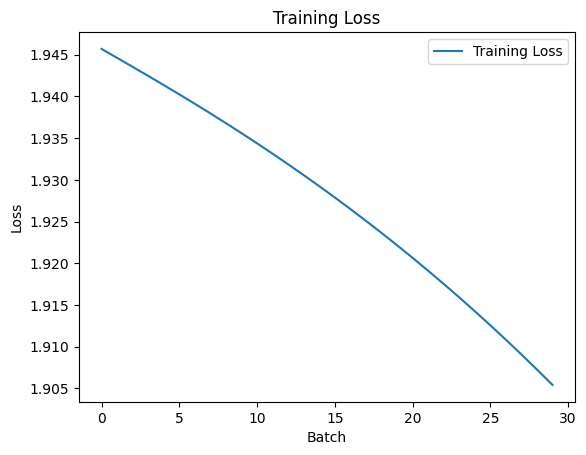

In [14]:
import time
import numpy as np
import matplotlib.pyplot as plt


# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
losses = []

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()